<a href="https://colab.research.google.com/github/DoubleCyclone/CNN-From-Scratch/blob/main/notebooks/CNN_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will build a **Convolutional Neural Network Model** with **NumPy** and train it on the [CIFAR-10 dataset](https://www.kaggle.com/c/cifar-10/). Hoping to achieve a test accuracy of 70%.

# 1 - Setup and Data Acquisition
I will start this menacing task by importing the packages required as usual.

In [1]:
from torchvision import datasets
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from tqdm import tqdm

After the package imports, the first thing I have to do is load the dataset. I will also split the training data into Training and Validation sets so that while training the model we can use the Validation set for a more accurate metrics summary of the model. I know that the dataset has 50000 training and 10000 test samples so I will divide it to 40000 training, 10000 validation and 10000 test samples instead.

In [2]:
# Load the train and test datasets
dataset_full = datasets.CIFAR10(root="data", train=True, download=True)
dataset_test = datasets.CIFAR10(root="data", train=False, download=True)

# Split the training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(dataset_full.data, dataset_full.targets, test_size=0.2, stratify=dataset_full.targets, random_state=42)
X_test = dataset_test.data
y_test = dataset_test.targets

print(f"Training data : {X_train.shape}, labels : {len(y_train)}")
print(f"Validation data : {X_val.shape}, labels : {len(y_val)}")
print(f"Test data : {X_test.shape}, labels : {len(y_test)}")
print(f"Classes : {dataset_full.classes}, count {len(dataset_full.classes)}")

# Transpose all data to fit PyTorch standards
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

print(f"Training data transposed : {X_train.shape}, labels : {len(y_train)}")
print(f"Validation data transposed : {X_val.shape}, labels : {len(y_val)}")
print(f"Test data transposed : {X_test.shape}, labels : {len(y_test)}")

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


Training data : (40000, 32, 32, 3), labels : 40000
Validation data : (10000, 32, 32, 3), labels : 10000
Test data : (10000, 32, 32, 3), labels : 10000
Classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], count 10
Training data transposed : (40000, 3, 32, 32), labels : 40000
Validation data transposed : (10000, 3, 32, 32), labels : 10000
Test data transposed : (10000, 3, 32, 32), labels : 10000


One sample's shape is 32x32x3 which represents the size of the image and the channels in that image. Channel count being 3 here means that the image is composed of Red, Green and Blue values on top of each other (RGB). If it was comprised of a single channel, that would have meant that the image was monochromatic. (Like in the [MNIST Digit Classification dataset](https://www.kaggle.com/code/hojjatk/read-mnist-dataset)). Also, there are 10 classes in the dataset comprised of some animal species and vehicles.

Let's visualize a few images to get an idea about how they look.

In [3]:
def visualize_random(X, size, amount) :
  # Pick random indexes
  rng = np.random.default_rng()
  random_idx = rng.choice(len(X), size=amount, replace=False)

  plt.figure(figsize=(amount * 3, 2.5)) # Adjust figure size for better visualization
  for j, i in enumerate(random_idx) :
    # Transpose image from (Channels, Height, Width) to (Height, Width, Channels)
    # before creating PIL Image object
    img_data = np.transpose(X[i], (1, 2, 0))
    # Resize image using LANCZOS filter for high-quality upscaling
    img = Image.fromarray(img_data).resize((size, size), resample=Image.Resampling.LANCZOS)
    plt.subplot(1, amount, j + 1)
    plt.imshow(img)
    plt.title(f"Index: {i}, Label : {dataset_full.classes[y_train[i]]}") # Set the index and class as the title
    plt.axis('off') # Hide axes for cleaner image display
  plt.tight_layout() # Adjust subplot parameters for a tight layout
  plt.show() # Display the plot

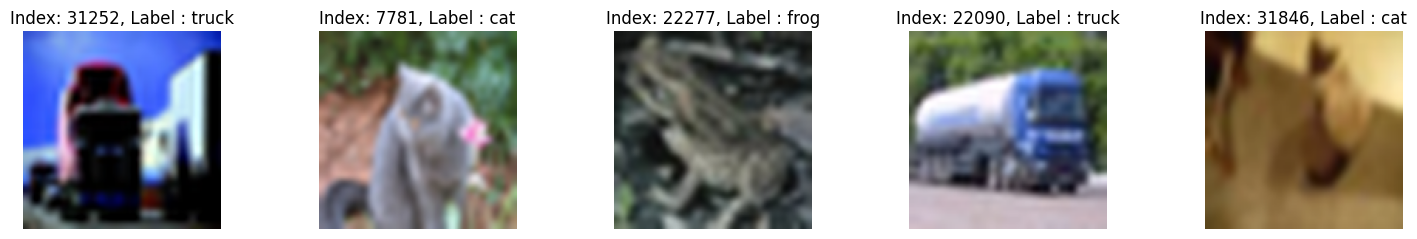

In [4]:
visualize_random(X_train, 128, 5)

As the images are really small originally, upscaling them leads to low res visualizations but they are still understandable.

We use CNNs instead of NNs for image classifications because they keep information about the pixels' neighbors as well as the pixels themselves, learning about patterns by themselves.

For my simple model, I will have the architecture built like ```Conv(32 filters) -> MaxPooling -> Conv(64 filters) -> MaxPooling -> Dense(128) -> Dense(10)``` and I will use filters of size 3x3 with no stride or padding for the convolution and a window size of 2 for the **Max Pooling**.

# 2 - Building CNN Mathematical Components
At first, I need to scale the data from the range 0-255 to a smaller range like 0-1 to avoid the gradient explosion problem.


In [5]:
def scaledown(data) :
  return data / 255.0

In [6]:
test_images = scaledown(X_train[:10])
print(test_images.shape)
print(test_images[0])

(10, 3, 32, 32)
[[[0.21960784 0.23137255 0.2745098  ... 0.54117647 0.56078431 0.61568627]
  [0.21568627 0.24705882 0.31764706 ... 0.52941176 0.67058824 0.63921569]
  [0.25098039 0.31372549 0.31764706 ... 0.64705882 0.76078431 0.57254902]
  ...
  [0.17647059 0.19607843 0.2627451  ... 0.52941176 0.44313725 0.50196078]
  [0.18431373 0.18431373 0.25098039 ... 0.43921569 0.39607843 0.43137255]
  [0.16470588 0.20784314 0.24705882 ... 0.49019608 0.43137255 0.36862745]]

 [[0.19607843 0.2        0.25490196 ... 0.60392157 0.61960784 0.65882353]
  [0.19607843 0.22745098 0.30196078 ... 0.58431373 0.73333333 0.69411765]
  [0.24313725 0.29803922 0.30588235 ... 0.70196078 0.82745098 0.62352941]
  ...
  [0.16078431 0.18039216 0.24705882 ... 0.52941176 0.44313725 0.49803922]
  [0.17647059 0.17647059 0.24313725 ... 0.41568627 0.37254902 0.40784314]
  [0.16470588 0.20392157 0.23529412 ... 0.44705882 0.39607843 0.34117647]]

 [[0.16470588 0.16078431 0.2        ... 0.58039216 0.6        0.64705882]
  [0.1

Seems to work so let's run it on all the data.

In [7]:
X_train_scaled = scaledown(X_train)
X_val_scaled = scaledown(X_val)
X_test_scaled = scaledown(X_test)

Then I need to convert the images from 3 dimensional arrays to 2 dimensional arrays by getting rid of the channel dimension and just concatenating the channels together in such a way that every column represents all the information gathered from one position from the sliding window technique (1 column = kernel size x channel size amount of data). This approach is called **im2col**.

In [8]:
def im2col(images, kernels) :
  _, kernel_channels, kernel_h, kernel_w = kernels.shape  # Get kernel dimensions

  B, C_img, H_img, W_img = images.shape # Get image dimensions

  # Calculate output dimensions
  output_h = H_img - kernel_h + 1
  output_w = W_img - kernel_w + 1

  # The number of patches for each image
  num_patches = output_h * output_w

  # The size of each flattened patch (image_channels * kernel_height * kernel_width)
  patch_size = C_img * kernel_h * kernel_w # C_img here refers to the input image's channel count

  # Initialize the output array with shape (Batch_size, patch_size, num_patches)
  output = np.empty((B, patch_size, num_patches))

  for b_idx in range(B): # Iterate through each image in the batch
    patch_count = 0
    for i in range(output_h): # Iterate through the height of the output feature map
      for j in range(output_w): # Iterate through the width of the output feature map
        # Extract the current patch and flatten it, assuming (C, H, W) for image slice
        patch = images[b_idx, :, i:i+kernel_h, j:j+kernel_w].flatten()
        # Assign the flattened patch as a column vector in the output array
        output[b_idx, :, patch_count] = patch
        patch_count += 1
  return output

In [9]:
test_kernels = np.ones(shape=(2, 3, 3, 3))
test_images_col = im2col(test_images, test_kernels)
print(f"Im2col transformed shape : {test_images_col.shape}")

Im2col transformed shape : (10, 27, 900)


Now that our manual implementation of the **im2col** function is working, I need to implement the convolution function. Meaning calculating the dot product between different parts of the image with kernels and extracting pattern information. While initializing the kernels, I will be using the **Kaiming (He)** Initialization which works well with **ReLU** activation function which I will use after the convolution processes. Also, it is better to include **im2col**, bias adding and reshaping in the convolution function so I will be doing that.

Let's start with simple kernel and bias creation functions.

In [10]:
def create_kernels(amount, channels, h, w) :
  kernels = np.empty(shape=(amount, channels, h, w)) # Create kernels array
  # initialize all the kernels
  for i in range(amount) :
    kernels[i] = np.random.randn(channels, h, w) * np.sqrt(2/kernels[0].size)
  return kernels

In [11]:
def create_biases(num_kernels):
    return np.zeros(num_kernels)

Let's use the newly created functions to create our test kernels and biases.

In [12]:
test_kernels = create_kernels(32, test_images.shape[1], 3, 3)
test_biases = create_biases(test_kernels.shape[0])
print(f"Test Kernels Shape : {test_kernels.shape}")
print(f"Test Biases Shape : {test_biases.shape}")

Test Kernels Shape : (32, 3, 3, 3)
Test Biases Shape : (32,)


Now the convolve function which will include **im2col** transformation.

In [13]:
def convolve(images, kernels, biases, padding='valid') :
  # Extract images' and kernels' shapes
  B, C_img, H_img, W_img = images.shape
  num_filters, _, kernel_h, kernel_w = kernels.shape

  # Apply padding if 'same' is specified
  if padding == 'same':
    # Calculate padding amount for 'same' padding
    pad_h = (kernel_h - 1) // 2 # 1
    pad_w = (kernel_w - 1) // 2 # 1
    # Apply padding to images. Padding tuples must match (B, C_img, H_img, W_img)
    images_processed = np.pad(images, ((0,0), (0,0), (pad_h, pad_h), (pad_w, pad_w)), mode='constant')
  else: # 'valid' or no padding
    images_processed = images

  # Extract dimensions from potentially padded images
  _, _, H_proc, W_proc = images_processed.shape

  # Calculate output dimensions based on processed images
  output_h = H_proc - kernel_h + 1
  output_w = W_proc - kernel_w + 1

  # Apply im2col transformation to the processed (potentially padded) images
  col_images = im2col(images_processed, kernels)  # (B, patch_size, num_patches)

  # Flatten kernels
  flattened_kernels = kernels.reshape(num_filters, -1)  # (num_filters, patch_size)

  # Convolve (matrix multiply)
  output = np.empty((B, num_filters, output_h * output_w))
  for i in range(B):
    # The dot product will now be (num_filters, patch_size) @ (patch_size, num_patches)
    # Resulting in (num_filters, num_patches), which is (5, 900) in this case.
    output[i] = np.dot(flattened_kernels, col_images[i])

  # Add biases
  for i in range(num_filters):
    output[:, i, :] += biases[i]

  # Reshape to spatial format
  output = output.reshape(B, num_filters, output_h, output_w)

  return output

Time to test that as well.

In [14]:
convolved_test_valid = convolve(test_images, test_kernels, test_biases, padding='valid')
print(f"Convolved output shape (valid padding): {convolved_test_valid.shape}")

# Test with 'same' padding
convolved_test_same = convolve(test_images, test_kernels, test_biases, padding='same')
print(f"Convolved output shape (same padding): {convolved_test_same.shape}")

Convolved output shape (valid padding): (10, 32, 30, 30)
Convolved output shape (same padding): (10, 32, 32, 32)


The convolution gave us feature maps which have the correct shape. The next step will be applying an activation function on this. I will be using **ReLU** as I have mentioned before.

In [15]:
def ReLU(data) :
  return np.maximum(0, data)

Run a quick test.

In [16]:
print(f"Min before ReLU : {np.min(convolved_test_same)}")
convolved_test_same = ReLU(convolved_test_same)
print(f"Min after ReLU : {np.min(convolved_test_same)}")

Min before ReLU : -3.020593964832659
Min after ReLU : 0.0


ReLU is done as well which was probably the easiest part yet... Now I need to implement something called a **Max Pooling** which will decrease the input feature maps while retaining the most information. I will use 2x2 windows with a stride of 2 which is the most common setup for a pooling layer.

In [17]:
def apply_pooling(data, window_size) :
  B, C, H, W = data.shape # Get dimensions
  output_h = H // window_size # reduce output H
  output_w = W // window_size # reduce output W

  output = np.empty(shape=(B, C, output_h, output_w)) # prepare output array
  max_indices = np.empty(shape=(B, C, output_h, output_w, 2), dtype=int)  # Store (h, w) indices

  for b in range(B) : # for every image
    for c in range(C) : # for every channel
      for i in range(output_h) :
        for j in range(output_w) :
          # Calculate the start and end indices for the current window
          h_start = i * window_size
          h_end = h_start + window_size
          w_start = j * window_size
          w_end = w_start + window_size
          window = data[b, c, h_start:h_end, w_start:w_end]
          output[b, c, i, j] = np.max(window)

          # Find where the max came from (relative to window)
          max_pos = np.unravel_index(np.argmax(window), window.shape)
          # Store absolute position
          max_indices[b, c, i, j, 0] = h_start + max_pos[0]
          max_indices[b, c, i, j, 1] = w_start + max_pos[1]

  return output, max_indices

Max pooling has been implemented as well, let's test if it correctly reduces the size of our images.

In [18]:
pooled_test, _ = apply_pooling(convolved_test_same, 2)
print(f"Max Pooled : {pooled_test.shape}")

Max Pooled : (10, 32, 16, 16)


Yes! With a window size of 2, the height and weight of the images got halved which is perfect. For a realistic test, let's run the convolution and pooling layers once more to see if anything breaks as I mentioned that I would use two of each at the start.

In [19]:
# create new test kernels and biases
test_kernels_2 = create_kernels(64, pooled_test.shape[1], 3, 3)
test_biases_2 = create_biases(test_kernels_2.shape[0])

# Run convolution again
convolved_test_2 = convolve(pooled_test, test_kernels_2, test_biases_2, padding='same')
print(f"Convolved for the second time : {convolved_test_2.shape}")

# Run pooling again
pooled_test_2, _ = apply_pooling(convolved_test_2, 2)
print(f"Pooled for the second time : {pooled_test_2.shape}")

Convolved for the second time : (10, 64, 16, 16)
Pooled for the second time : (10, 64, 8, 8)


Okay the outputs' shapes look exactly as I wanted as well. Now I need a flattening function for these images to feed them into the dense (Fully Connected Neural Network) layer which I will also implement afterwards.

In [20]:
def flatten(data) :
  B = data.shape[0]
  data = np.reshape(data, (B, -1))
  return data

In [21]:
flattened_test = flatten(pooled_test_2)
print(f"Flattened data shape : {flattened_test.shape}")

Flattened data shape : (10, 4096)


Nice. The output's shape before the first Dense layer corresponds to 4096 inputs for every sample. For the last dense layer, I need another activation function before the loss calculation. For this project, I will use the **Softmax** activation function and the **Cross Entropy** loss functions. Now let's implement them.

In [22]:
def softmax(logits) :
  if logits.ndim == 1:  # Single sample
    shifted = logits - np.max(logits) # Subtract max for numerical stability (prevents overflow)
    exp_vals = np.exp(shifted)
    return exp_vals / np.sum(exp_vals)
  else:  # Batch
    shifted = logits - np.max(logits, axis=1, keepdims=True) # Subtract max for numerical stability (prevents overflow)
    exp_vals = np.exp(shifted)
    return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

In [23]:
test_preds = softmax(np.random.rand(10))
print(f"Probabilities : {test_preds}")
print(f"Sum of probabilities : {np.sum(test_preds)}")

Probabilities : [0.14490854 0.09231732 0.06045222 0.05845329 0.07793605 0.09545344
 0.14078322 0.14556401 0.06672271 0.1174092 ]
Sum of probabilities : 1.0


Great, with dummy data, it can be seen that the method correctly converts randomly initialized logits into probabilities and their sum equals to 1. (Well, there might be microscopic errors). Now it is time to implement the **Cross Entropy Loss** function. And for the cross entropy loss to work, I will have to turn true labels into one-hot encoded versions.

In [24]:
def one_hot_encode(labels, num_classes) :
  labels = np.array(labels)
  one_hot = np.zeros((labels.shape[0], num_classes))
  one_hot[np.arange(labels.shape[0]), labels] = 1
  return one_hot

In [25]:
# Create encoded labels
y_train_oh = one_hot_encode(y_train, len(dataset_full.classes))
y_val_oh = one_hot_encode(y_val, len(dataset_full.classes))
y_test_oh = one_hot_encode(y_test, len(dataset_full.classes))

# Pick random index
rand_idx = random.randint(0, len(y_train) + 1)

print(f"Random record of original labels : Index {rand_idx}, Original {y_train[rand_idx]}, Encoded {y_train_oh[rand_idx]} ")

Random record of original labels : Index 14735, Original 9, Encoded [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 


Now that one-hot encoding is implemented, I can create the **Cross Entropy** Loss function as well.

In [26]:
def cross_entropy_loss(preds, true_labels) :
  # Add small epsilon to prevent log(0)
  epsilon = 1e-15
  preds = np.clip(preds, epsilon, 1 - epsilon)

  # Calculate loss
  batch_size = preds.shape[0] if preds.ndim > 1 else 1
  return -np.sum(true_labels * np.log(preds)) / batch_size

In [27]:
test_loss = cross_entropy_loss(test_preds, y_train_oh[1])
print(f"Total loss : {test_loss}")

Total loss : 1.927139342405278


Great, time to work on the Dense layers.

In [28]:
class Dense() :
  def __init__(self, input_amount, output_amount) :
    self.input_amount = input_amount
    self.output_amount = output_amount
    self.weights = np.random.randn(input_amount, output_amount) * np.sqrt(2.0 / input_amount) # He Initialization
    self.biases = np.zeros(shape=(output_amount))
    print(f"Created Dense Layer with {input_amount} Inputs and {output_amount} Outputs")
    print(f"Weights shape : {self.weights.shape}")
    print(f"Biases shape : {self.biases.shape}\n")

  def forward(self, data, activation='relu') :
    # Ensure data is 2D
    if data.ndim == 1:
      data = data.reshape(1, -1)

    cache = {}
    cache['input'] = data

    # Linear transformation
    weighted = np.dot(data, self.weights)
    biased = weighted + self.biases

    cache['input'] = data
    cache['weighted'] = weighted
    cache['biased'] = biased

    # Apply activation
    if activation == 'relu':
      output = ReLU(biased)
    elif activation == 'softmax':
      output = softmax(biased)  # No ReLU before softmax!
    else:  # 'none'
      output = biased

    cache['output'] = output

    return output, cache

Now for a quick test.

In [29]:
# Initialize first dense layer
dense_1 = Dense(flattened_test.shape[1], 128)

# Run forward pass once to test
logits_1, cache_1 = dense_1.forward(flattened_test, 'relu')

for key, val in cache_1.items() : # Print output shapes
  print(f"{key} shape : {val.shape}")

print()

# Initialize second (last) dense layer
dense_2 = Dense(128, len(dataset_full.classes))

# Run forward pass on the second (last) layer
preds_2, cache_2 = dense_2.forward(cache_1['output'], 'softmax')

for key, val in cache_2.items() : # Print output shapes
  print(f"{key} shape : {val.shape}")

print(f"Test sample predictions sum : {np.sum(cache_2['output'][0])}") # Should be 1 (or very very close)

Created Dense Layer with 4096 Inputs and 128 Outputs
Weights shape : (4096, 128)
Biases shape : (128,)

input shape : (10, 4096)
weighted shape : (10, 128)
biased shape : (10, 128)
output shape : (10, 128)

Created Dense Layer with 128 Inputs and 10 Outputs
Weights shape : (128, 10)
Biases shape : (10,)

input shape : (10, 128)
weighted shape : (10, 10)
biased shape : (10, 10)
output shape : (10, 10)
Test sample predictions sum : 1.0


# 3 - Complete Forward Propagation
As all the mathematical components were implemented, it is finally time to implement a complete forward propagation method.

In [30]:
def cnn_np_forward(data, labels, kernels_1, biases_1, kernels_2, biases_2,
                   window_size, dense_layer_1, dense_layer_2):
    cache = {}

    # Save original input
    cache['input'] = data

    # === Conv Block 1 ===
    cache['kernels_1'] = kernels_1
    cache['biases_1'] = biases_1

    conv1_out = convolve(data, kernels_1, biases_1, 'same')
    cache['conv1_out'] = conv1_out

    relu1_out = ReLU(conv1_out)
    cache['relu1_out'] = relu1_out

    pool1_out, pool1_indices = apply_pooling(relu1_out, window_size)
    cache['pool1_out'] = pool1_out
    cache['pool1_indices'] = pool1_indices  # CRITICAL for backprop!

    # === Conv Block 2 ===
    cache['kernels_2'] = kernels_2
    cache['biases_2'] = biases_2

    conv2_out = convolve(pool1_out, kernels_2, biases_2, 'same')
    cache['conv2_out'] = conv2_out

    relu2_out = ReLU(conv2_out)
    cache['relu2_out'] = relu2_out

    pool2_out, pool2_indices = apply_pooling(relu2_out, window_size)
    cache['pool2_out'] = pool2_out
    cache['pool2_indices'] = pool2_indices

    # === Dense Layers ===
    flattened = flatten(pool2_out)
    cache['flattened'] = flattened
    cache['flattened_shape'] = pool2_out.shape  # To reshape back during backprop

    dense1_out, dense1_cache = dense_layer_1.forward(flattened, 'relu')
    cache['dense1_cache'] = dense1_cache

    preds, dense2_cache = dense_layer_2.forward(dense1_out, 'softmax')
    cache['dense2_cache'] = dense2_cache
    cache['preds'] = preds

    # === Loss ===
    avg_loss = cross_entropy_loss(preds, labels)
    cache['labels'] = labels
    cache['loss'] = avg_loss

    return preds, cache, avg_loss

Now I can finally run the forward propagation and basically prediction as well for an untrained model.

In [31]:
# === Initialize all layers ONCE ===

# Conv layer 1: 3 channels → 32 filters
kernels_1 = create_kernels(32, 3, 3, 3)
biases_1 = create_biases(32)

# Conv layer 2: 32 channels → 64 filters
kernels_2 = create_kernels(64, 32, 3, 3)
biases_2 = create_biases(64)

# Dense layers (already initialized)
dense_layer_1 = Dense(4096, 128)
dense_layer_2 = Dense(128, 10)

# === Run forward pass ===
test_preds, cache, loss = cnn_np_forward(
    X_train_scaled[:100],
    y_train_oh[:100],
    kernels_1, biases_1,
    kernels_2, biases_2,
    2,  # window_size
    dense_layer_1,
    dense_layer_2
)

print(f"Loss: {loss:.4f}")
print(f"Predicted class: {dataset_full.classes[np.argmax(test_preds[0])]}")
print(f"True class: {dataset_full.classes[y_train[0]]}")

Created Dense Layer with 4096 Inputs and 128 Outputs
Weights shape : (4096, 128)
Biases shape : (128,)

Created Dense Layer with 128 Inputs and 10 Outputs
Weights shape : (128, 10)
Biases shape : (10,)

Loss: 2.7618
Predicted class: cat
True class: frog


Obviously as the model hasn't been trained, the prediction is random. Which is why we train models in the first place.
# 4 - Backward Propagation
After forward propagation (prediction), we get a loss value that tells us how wrong the prediction was. By using that value, we update our weights and biases so that the model learns and does better the next time. To calculate how much each weight/bias contributed to the loss (and to decide how much each of them should change) we implement something called "**Backward Propagation**". This is because the process is done in the reverse order compared to Forward Propagation.

In [32]:
def conv_backward(dL_doutput, input_data, kernels, padding='same'):
  # Extract input data, kernel and output shape
  B, C_in, H_in, W_in = input_data.shape
  num_filters, _, k_h, k_w = kernels.shape
  _, _, H_out, W_out = dL_doutput.shape

  # Apply same padding to input if needed
  if padding == 'same':
    pad_h = (k_h - 1) // 2
    pad_w = (k_w - 1) // 2
    input_padded = np.pad(input_data, ((0,0), (0,0), (pad_h, pad_h), (pad_w, pad_w)), mode='constant')
  else:
    input_padded = input_data
    pad_h = pad_w = 0

  # Gradient w.r.t Biases
  # Sum gradient across batch and spatial dimensions
  dL_dbiases = np.sum(dL_doutput, axis=(0, 2, 3))  # (num_filters,)

  # Gradient w.r.t Kernels
  dL_dkernels = np.zeros_like(kernels)  # (num_filters, C_in, k_h, k_w)

  dL_dkernels = np.zeros_like(kernels)
  # For each filter
  for f in range(num_filters):
    for i in range(k_h):
      for j in range(k_w):
        # Vectorized over channels and batch
        input_region = input_padded[:, :, i:i+H_out, j:j+W_out]  # (B, C_in, H_out, W_out)
        grad_region = dL_doutput[:, f:f+1, :, :]  # (B, 1, H_out, W_out)
        dL_dkernels[f, :, i, j] = np.sum(input_region * grad_region, axis=(0, 2, 3)) / B

  # Gradient w.r.t Input
  # Need to "spread" gradient back through convolution
  _, _, H_padded, W_padded = input_padded.shape
  dL_dinput_padded = np.zeros((B, C_in, H_padded, W_padded))

  # For each sample in batch
  for b in range(B):
    # For each output channel (filter)
    for f in range(num_filters):
      # For each output position
      for i in range(H_out):
        for j in range(W_out):
          # The gradient at this output position affects a k_h x k_w region of input
          # Add contribution from this filter
          dL_dinput_padded[b, :, i:i+k_h, j:j+k_w] += (kernels[f] * dL_doutput[b, f, i, j])

  # Remove padding if it was added
  if padding == 'same':
    dL_dinput = dL_dinput_padded[:, :, pad_h:-pad_h, pad_w:-pad_w]
  else:
    dL_dinput = dL_dinput_padded

  return dL_dkernels, dL_dbiases, dL_dinput

In [33]:
def cnn_np_backward(cache, dense_layer_1, dense_layer_2, window_size=2):
  gradients = {}

  # Softmax + Cross-Entropy Gradient
  # Beautiful simplified form: preds - true_labels
  dL_dsoftmax = cache['preds'] - cache['labels']  # (B, 10)

  # Dense Layer 2 Backward
  # Gradient w.r.t weights: input.T @ gradient
  gradients['dense2_weights'] = np.dot(cache['dense2_cache']['input'].T, dL_dsoftmax) / dL_dsoftmax.shape[0]  # Average over batch: (128, 10)

  # Gradient w.r.t biases: sum over batch
  gradients['dense2_biases'] = np.sum(dL_dsoftmax, axis=0) / dL_dsoftmax.shape[0]  # (10,)

  # Gradient w.r.t input: gradient @ weights.T
  dL_ddense2_input = np.dot(dL_dsoftmax, dense_layer_2.weights.T)  # (B, 128)

  # ReLU Backward (between Dense layers)
  # Gradient passes through where input > 0, zero elsewhere
  dL_drelu = dL_ddense2_input * (cache['dense1_cache']['biased'] > 0)  # (B, 128)

  # Dense Layer 1 Backward
  # Gradient w.r.t weights
  gradients['dense1_weights'] = np.dot(cache['dense1_cache']['input'].T, dL_drelu) / dL_drelu.shape[0]  # (4096, 128)

  # Gradient w.r.t biases
  gradients['dense1_biases'] = np.sum(dL_drelu, axis=0) / dL_drelu.shape[0]  # (128,)

  # Gradient w.r.t input
  dL_ddense1_input = np.dot(dL_drelu, dense_layer_1.weights.T)  # (B, 4096)

  # Unflatten (Reshape) Backward
  # Just reshape gradient back to 4D: (B, 4096) -> (B, 64, 8, 8)
  dL_dpool2_out = dL_ddense1_input.reshape(cache['flattened_shape'])  # (B, 64, 8, 8)

  # Max Pooling 2 Backward
  # Create zeros with shape before pooling: (B, 64, 16, 16)
  B, C, pool_H, pool_W = dL_dpool2_out.shape
  unpooled_H = pool_H * window_size
  unpooled_W = pool_W * window_size
  dL_drelu2_out = np.zeros((B, C, unpooled_H, unpooled_W))

  # Route gradient to max positions
  pool2_indices = cache['pool2_indices']
  for b in range(B):
    for c in range(C):
      for i in range(pool_H):
        for j in range(pool_W):
          # Get where the max came from
          max_h = pool2_indices[b, c, i, j, 0]
          max_w = pool2_indices[b, c, i, j, 1]
          # Place gradient at that position
          dL_drelu2_out[b, c, max_h, max_w] = dL_dpool2_out[b, c, i, j]

  # ReLU 2 Backward
  # Gradient passes through where conv2 output > 0
  dL_dconv2_out = dL_drelu2_out * (cache['conv2_out'] > 0)  # (B, 64, 16, 16)

  # Convolution 2 Backward
  # This is the hardest part!
  dL_dkernels2, dL_dbiases2, dL_dpool1_out = conv_backward(dL_dconv2_out, cache['pool1_out'], cache['kernels_2'], padding='same')

  gradients['kernels_2'] = dL_dkernels2
  gradients['biases_2'] = dL_dbiases2

  # Max Pooling 1 Backward
  B, C, pool_H, pool_W = dL_dpool1_out.shape
  unpooled_H = pool_H * window_size
  unpooled_W = pool_W * window_size
  dL_drelu1_out = np.zeros((B, C, unpooled_H, unpooled_W))

  pool1_indices = cache['pool1_indices']
  for b in range(B):
    for c in range(C):
      for i in range(pool_H):
        for j in range(pool_W):
          max_h = pool1_indices[b, c, i, j, 0]
          max_w = pool1_indices[b, c, i, j, 1]
          dL_drelu1_out[b, c, max_h, max_w] = dL_dpool1_out[b, c, i, j]

  # ReLU 1 Backward
  dL_dconv1_out = dL_drelu1_out * (cache['conv1_out'] > 0)  # (B, 32, 32, 32)

  # Convolution 1 Backward
  dL_dkernels1, dL_dbiases1, dL_dinput = conv_backward(dL_dconv1_out, cache['input'], cache['kernels_1'], padding='same')

  gradients['kernels_1'] = dL_dkernels1
  gradients['biases_1'] = dL_dbiases1

  return gradients

In [34]:
# Run backward pass
gradients = cnn_np_backward(cache, dense_layer_1, dense_layer_2, window_size=2)

# Check gradient shapes
print("\n=== Gradient Shapes ===")
print(f"Dense2 weights gradient: {gradients['dense2_weights'].shape} (should be {dense_layer_2.weights.shape})")
print(f"Dense2 biases gradient: {gradients['dense2_biases'].shape} (should be {dense_layer_2.biases.shape})")
print(f"Dense1 weights gradient: {gradients['dense1_weights'].shape} (should be {dense_layer_1.weights.shape})")
print(f"Dense1 biases gradient: {gradients['dense1_biases'].shape} (should be {dense_layer_1.biases.shape})")
print(f"Kernels2 gradient: {gradients['kernels_2'].shape} (should be {kernels_2.shape})")
print(f"Biases2 gradient: {gradients['biases_2'].shape} (should be {biases_2.shape})")
print(f"Kernels1 gradient: {gradients['kernels_1'].shape} (should be {kernels_1.shape})")
print(f"Biases1 gradient: {gradients['biases_1'].shape} (should be {biases_1.shape})")


=== Gradient Shapes ===
Dense2 weights gradient: (128, 10) (should be (128, 10))
Dense2 biases gradient: (10,) (should be (10,))
Dense1 weights gradient: (4096, 128) (should be (4096, 128))
Dense1 biases gradient: (128,) (should be (128,))
Kernels2 gradient: (64, 32, 3, 3) (should be (64, 32, 3, 3))
Biases2 gradient: (64,) (should be (64,))
Kernels1 gradient: (32, 3, 3, 3) (should be (32, 3, 3, 3))
Biases1 gradient: (32,) (should be (32,))


# 5 - Training Loop
A training loop is comprised of multiple forward and backward propagations to get the model to predict as best as possible. Before the actual loop though, I would like to combine the methods I created until now to build a definitive CNN Numpy Model class which would make things a lot easier. This model will have a proper initialization, forward and backward propagation methods and a parameter update function.

In [35]:
class CNN_model() :
  def __init__(self, kernel_count, kernel_h, kernel_w, kernel_c, window_size) :
    # Initialize 2 kernels
    self.kernels_1 = create_kernels(kernel_count, kernel_c, kernel_h, kernel_w)
    self.kernels_2 = create_kernels(kernel_count*2, kernel_count, kernel_h, kernel_w)
    # Initialize biases for the kernels
    self.biases_1 = create_biases(kernel_count)
    self.biases_2 = create_biases(kernel_count*2)
    # Determine pooling window size
    self.window_size = window_size
    # Initialize 2 Dense Layers
    self.dense_1 = Dense(4096, 128)
    self.dense_2 = Dense(128, len(dataset_full.classes))
    print(f"Created CNN Model!")

  def forward(self, X, y) :
    preds, cache, avg_loss = cnn_np_forward(X, y, self.kernels_1, self.biases_1, self.kernels_2, self.biases_2, self.window_size, self.dense_1, self.dense_2)
    return preds, cache, avg_loss

  def backward(self, cache) :
    gradients = cnn_np_backward(cache, self.dense_1, self.dense_2, self.window_size)
    return gradients

  def update_parameters(self, gradients, learning_rate) :
    self.kernels_1 = self.kernels_1 - (gradients['kernels_1'] * learning_rate)
    self.kernels_2 = self.kernels_2 - (gradients['kernels_2'] * learning_rate)
    self.biases_1 = self.biases_1 - (gradients['biases_1'] * learning_rate)
    self.biases_2 = self.biases_2 - (gradients['biases_2'] * learning_rate)
    self.dense_1.weights = self.dense_1.weights - (gradients['dense1_weights'] * learning_rate)
    self.dense_2.weights = self.dense_2.weights - (gradients['dense2_weights'] * learning_rate)
    self.dense_1.biases = self.dense_1.biases - (gradients['dense1_biases'] * learning_rate)
    self.dense_2.biases = self.dense_2.biases - (gradients['dense2_biases'] * learning_rate)

  def predict(self, X) :
    # Create dummy labels as we aren't gonna need actual labels here
    dummy_labels = np.zeros((X.shape[0], len(dataset_full.classes)))
    # Run forward propagation for predictions
    preds, _, _ = self.forward(X, dummy_labels)
    # Reverse OH encoding
    return np.argmax(preds, axis=1)

In [36]:
model_np = CNN_model(32, 3, 3, 3, 2)

Created Dense Layer with 4096 Inputs and 128 Outputs
Weights shape : (4096, 128)
Biases shape : (128,)

Created Dense Layer with 128 Inputs and 10 Outputs
Weights shape : (128, 10)
Biases shape : (10,)

Created CNN Model!


Finally it is time for the training loop. Here I will initialize the parameters and then implement a function for model training. I could add Learning Rate Scheduling but as I will only be training for 5 epochs, I don't think the model is going to plateau or have hardships converging so in this iteration of the notebook I will not include it.

In [37]:
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
    # Store losses for plotting
    train_losses = []
    val_losses = []
    # Calculate batch count
    batch_count = X_train.shape[0] // batch_size

    print(f"Training for {epochs} epochs with batch size {batch_size}")
    print(f"Total batches per epoch: {batch_count}")
    print(f"Learning rate: {learning_rate}\n")

    for epoch in range(epochs):  # Remove tqdm here for cleaner output
        print(f"\n{'='*50}")
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"{'='*50}")

        # TRAINING
        # Shuffle training data to prevent order bias
        random_indices = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[random_indices]
        y_train_shuffled = y_train[random_indices]

        epoch_losses = []

        # Mini batching with tqdm
        for batch in tqdm(range(batch_count), desc=f"Epoch {epoch+1}", leave=False):
            # Determine start and end points for a batch, then initialize the batch
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            # Run forward pass to predict, calculate losses and store intermediate values
            preds, cache, avg_loss_train = model.forward(X_batch, y_batch)
            epoch_losses.append(avg_loss_train)

            # Run backward pass to calculate how much each parameter contributed to the error
            gradients = model.backward(cache)

            # Update weights with respect to the gradients
            model.update_parameters(gradients, learning_rate)

        # Calculate average training loss for this epoch
        avg_train_loss = np.mean(epoch_losses)
        train_losses.append(avg_train_loss)

        # VALIDATION
        print("Running validation...")
        val_batch_count = X_val.shape[0] // batch_size
        val_epoch_losses = []

        for batch in range(val_batch_count):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            X_val_batch = X_val[start_idx:end_idx]
            y_val_batch = y_val[start_idx:end_idx]

            _, _, val_loss = model.forward(X_val_batch, y_val_batch)
            val_epoch_losses.append(val_loss)

        avg_val_loss = np.mean(val_epoch_losses)
        val_losses.append(avg_val_loss)

        # LOGGING
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

# 6 - Training and Evaluation
Training loop is complete with validation on top. Now it is time to train.

**(Unfortunately as the runtime on Colab is limited, I cannot fully train this model at the moment so the evaluation has to either be imperfect or later on if I find a way around)**

In [38]:
train_losses, val_losses = train_model(model_np, X_train_scaled[:1000], y_train_oh[:1000], X_val_scaled, y_val_oh, 5, 64, 0.01)

Training for 5 epochs with batch size 64
Total batches per epoch: 15
Learning rate: 0.01


Epoch 1/5


Running validation...
Train Loss: 2.4224
Val Loss: 2.2597

Epoch 2/5


Running validation...
Train Loss: 2.2372
Val Loss: 2.2210

Epoch 3/5


Running validation...
Train Loss: 2.1747
Val Loss: 2.1634

Epoch 4/5


Running validation...
Train Loss: 2.1335
Val Loss: 2.1454

Epoch 5/5


Running validation...
Train Loss: 2.0868
Val Loss: 2.1362


I also need a few more functions to run predictions (without altering the model parameters), and to evaluate the model performance.

In [39]:
def calculate_accuracy(model, X, y_true_oh):
  # Run predictions on the data
  predictions = model.predict(X)
  # Reverse OH encoding
  y_true = np.argmax(y_true_oh, axis=1)
  # Calculate accuracy
  accuracy = np.mean(predictions == y_true) * 100
  return accuracy

In [40]:
def evaluate_model(model, X_val, y_val, batch_size):
  # Calculate batch count
  batch_count = X_val.shape[0] // batch_size
  # Store losses
  losses = []

  print("Evaluating model...")
  for batch in tqdm(range(batch_count), desc="Evaluation", leave=False):
      # Determine batch indices
      start_idx = batch * batch_size
      end_idx = start_idx + batch_size
      X_batch = X_val[start_idx:end_idx]
      y_batch = y_val[start_idx:end_idx]

      # Run forward pass and store loss value
      _, _, loss = model.forward(X_batch, y_batch)
      losses.append(loss)

  # Calculate average loss
  avg_loss = np.mean(losses)
  # Calculate accuracy
  accuracy = calculate_accuracy(model, X_val, y_val)

  return avg_loss, accuracy

In [41]:
calculate_accuracy(model_np, X_val_scaled[:5000], y_val_oh[:5000])

np.float64(21.84)

# 7 - Visualization and Analysis
After all this training, how about I visualize what kinds of patterns the model learned by itself? This will be done by visualizing the weights from the filters (kernels) and capturing some intermediate results from a forward pass like the convolution and pooling outputs which could resemble edges, colors or textures.

In [55]:
def visualize_conv1_filters(model, save_path='conv1_filters.png'):
  # Get filters from first conv layer
  filters = model.kernels_1  # Shape: (32, 3, 3, 3) = (num_filters, channels, h, w)
  num_filters = filters.shape[0]

  # Create grid for visualization
  grid_size = int(np.ceil(np.sqrt(num_filters)))
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
  fig.suptitle('First Layer Convolutional Filters (3x3 RGB)', fontsize=16)

  for i, ax in enumerate(axes.flat):
    if i < num_filters:
      # Get filter (C, H, W) and transpose to (H, W, C) for RGB
      filter_img = filters[i].transpose(1, 2, 0)  # (H, W ,C)

      # Normalize to 0-1 for display
      filter_img = filter_img - filter_img.min()
      if filter_img.max() > 0:
        filter_img = filter_img / filter_img.max()

      # Display
      ax.imshow(filter_img)
      ax.set_title(f'Filter {i + 1}', fontsize=8)
      ax.axis('off')
    else:
      ax.axis('off')

  plt.tight_layout()
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
  plt.show()
  print(f"Saved to {save_path}")

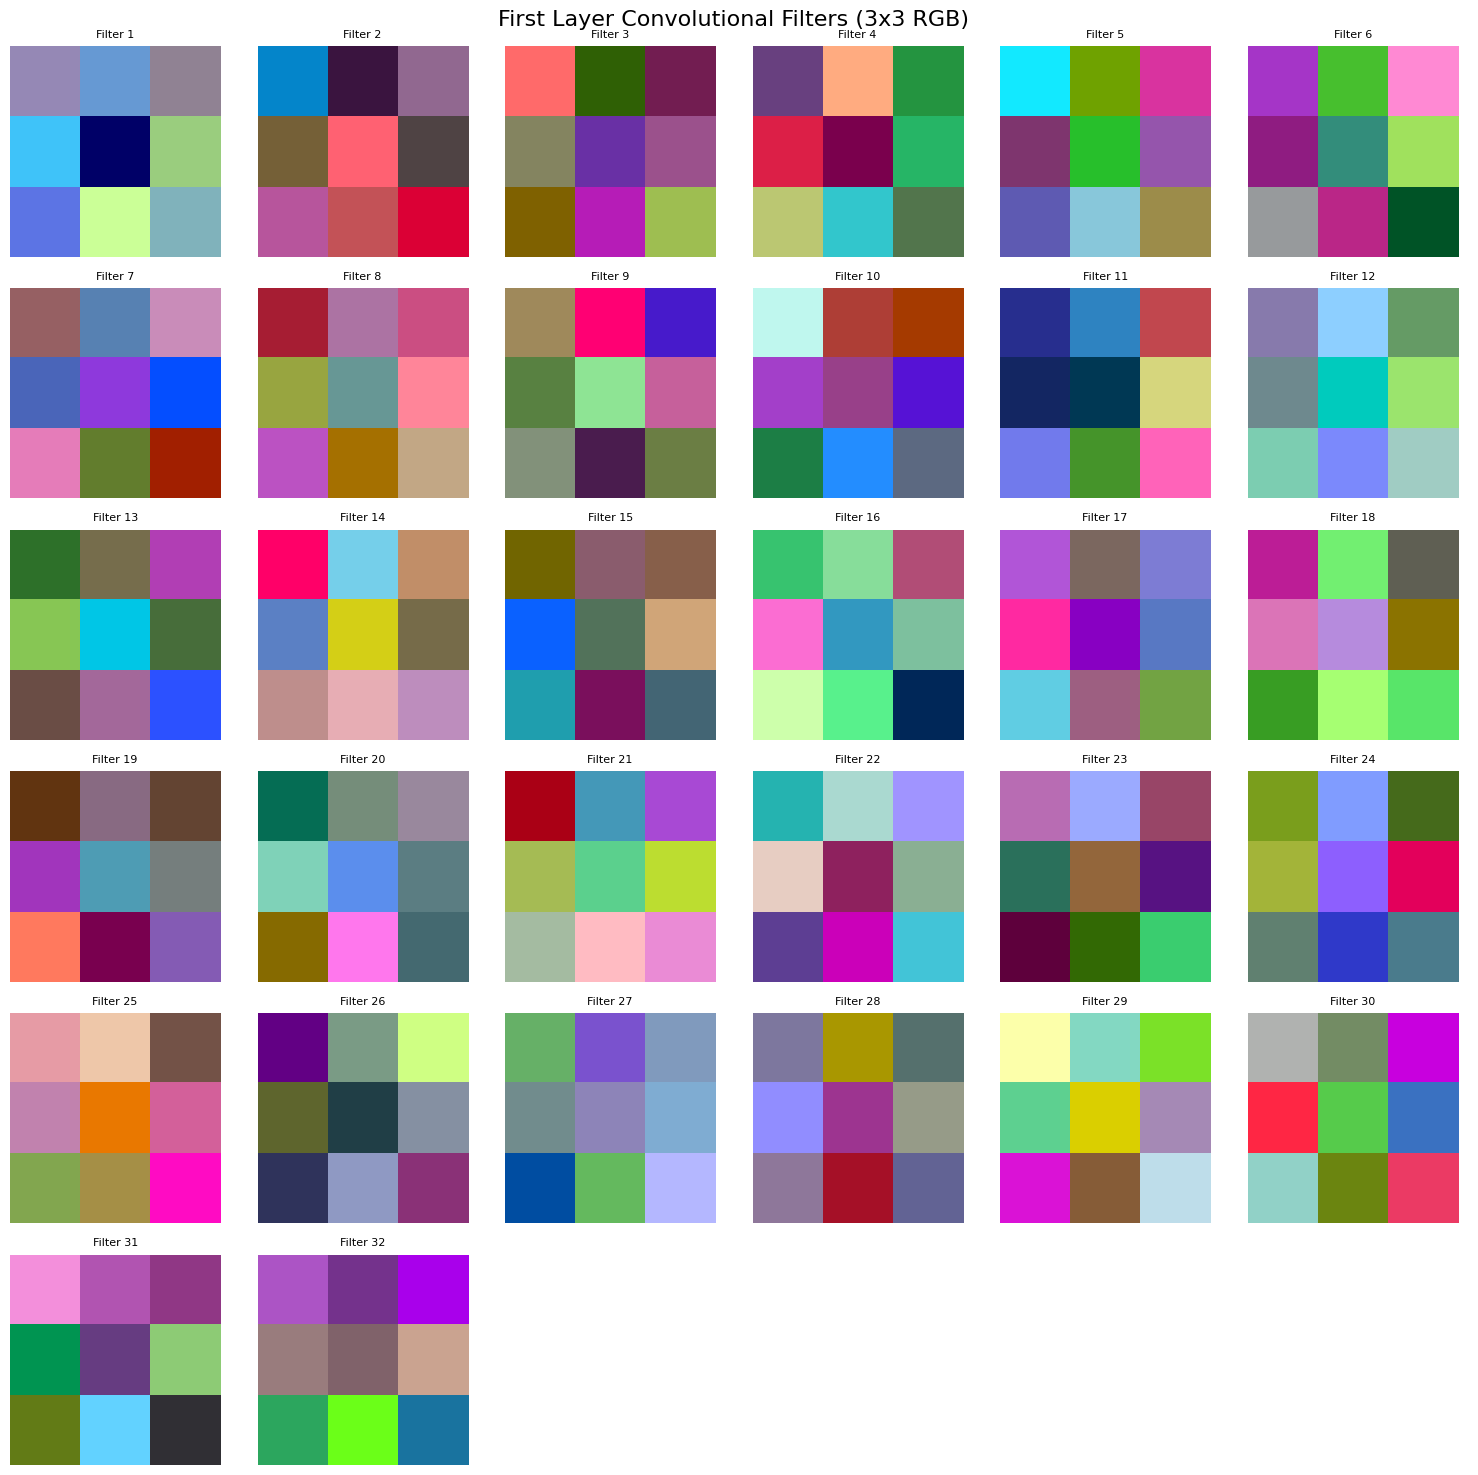

Saved to conv1_filters.png


In [56]:
visualize_conv1_filters(model_np)

In [49]:
def visualize_conv2_filters(model, save_path='conv2_filters.png'):
  filters = model.kernels_2  # Shape: (64, 32, 3, 3)

  num_filters = min(16, filters.shape[0])  # Show first 16 filters
  num_channels_to_show = 8  # Show first 8 channels of each filter

  fig, axes = plt.subplots(num_filters, num_channels_to_show, figsize=(20, 25))
  fig.suptitle('Second Layer Filters (showing first 8 of 32 channels)', fontsize=16)

  for i in range(num_filters):
    for j in range(num_channels_to_show):
      # Get one channel of one filter: (3, 3)
      filter_channel = filters[i, j, :, :]

      # Normalize
      filter_channel = filter_channel - filter_channel.min()
      if filter_channel.max() > 0:
        filter_channel = filter_channel / filter_channel.max()

      # Display
      axes[i, j].imshow(filter_channel, cmap='viridis')
      axes[i, j].axis('off')
      if j == 0:
        axes[i, j].set_ylabel(f'Filter {i}', fontsize=10)
      if i == 0:
        axes[i, j].set_title(f'Ch {j}', fontsize=8)

  plt.tight_layout()
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
  plt.show()
  print(f"Saved to {save_path}")

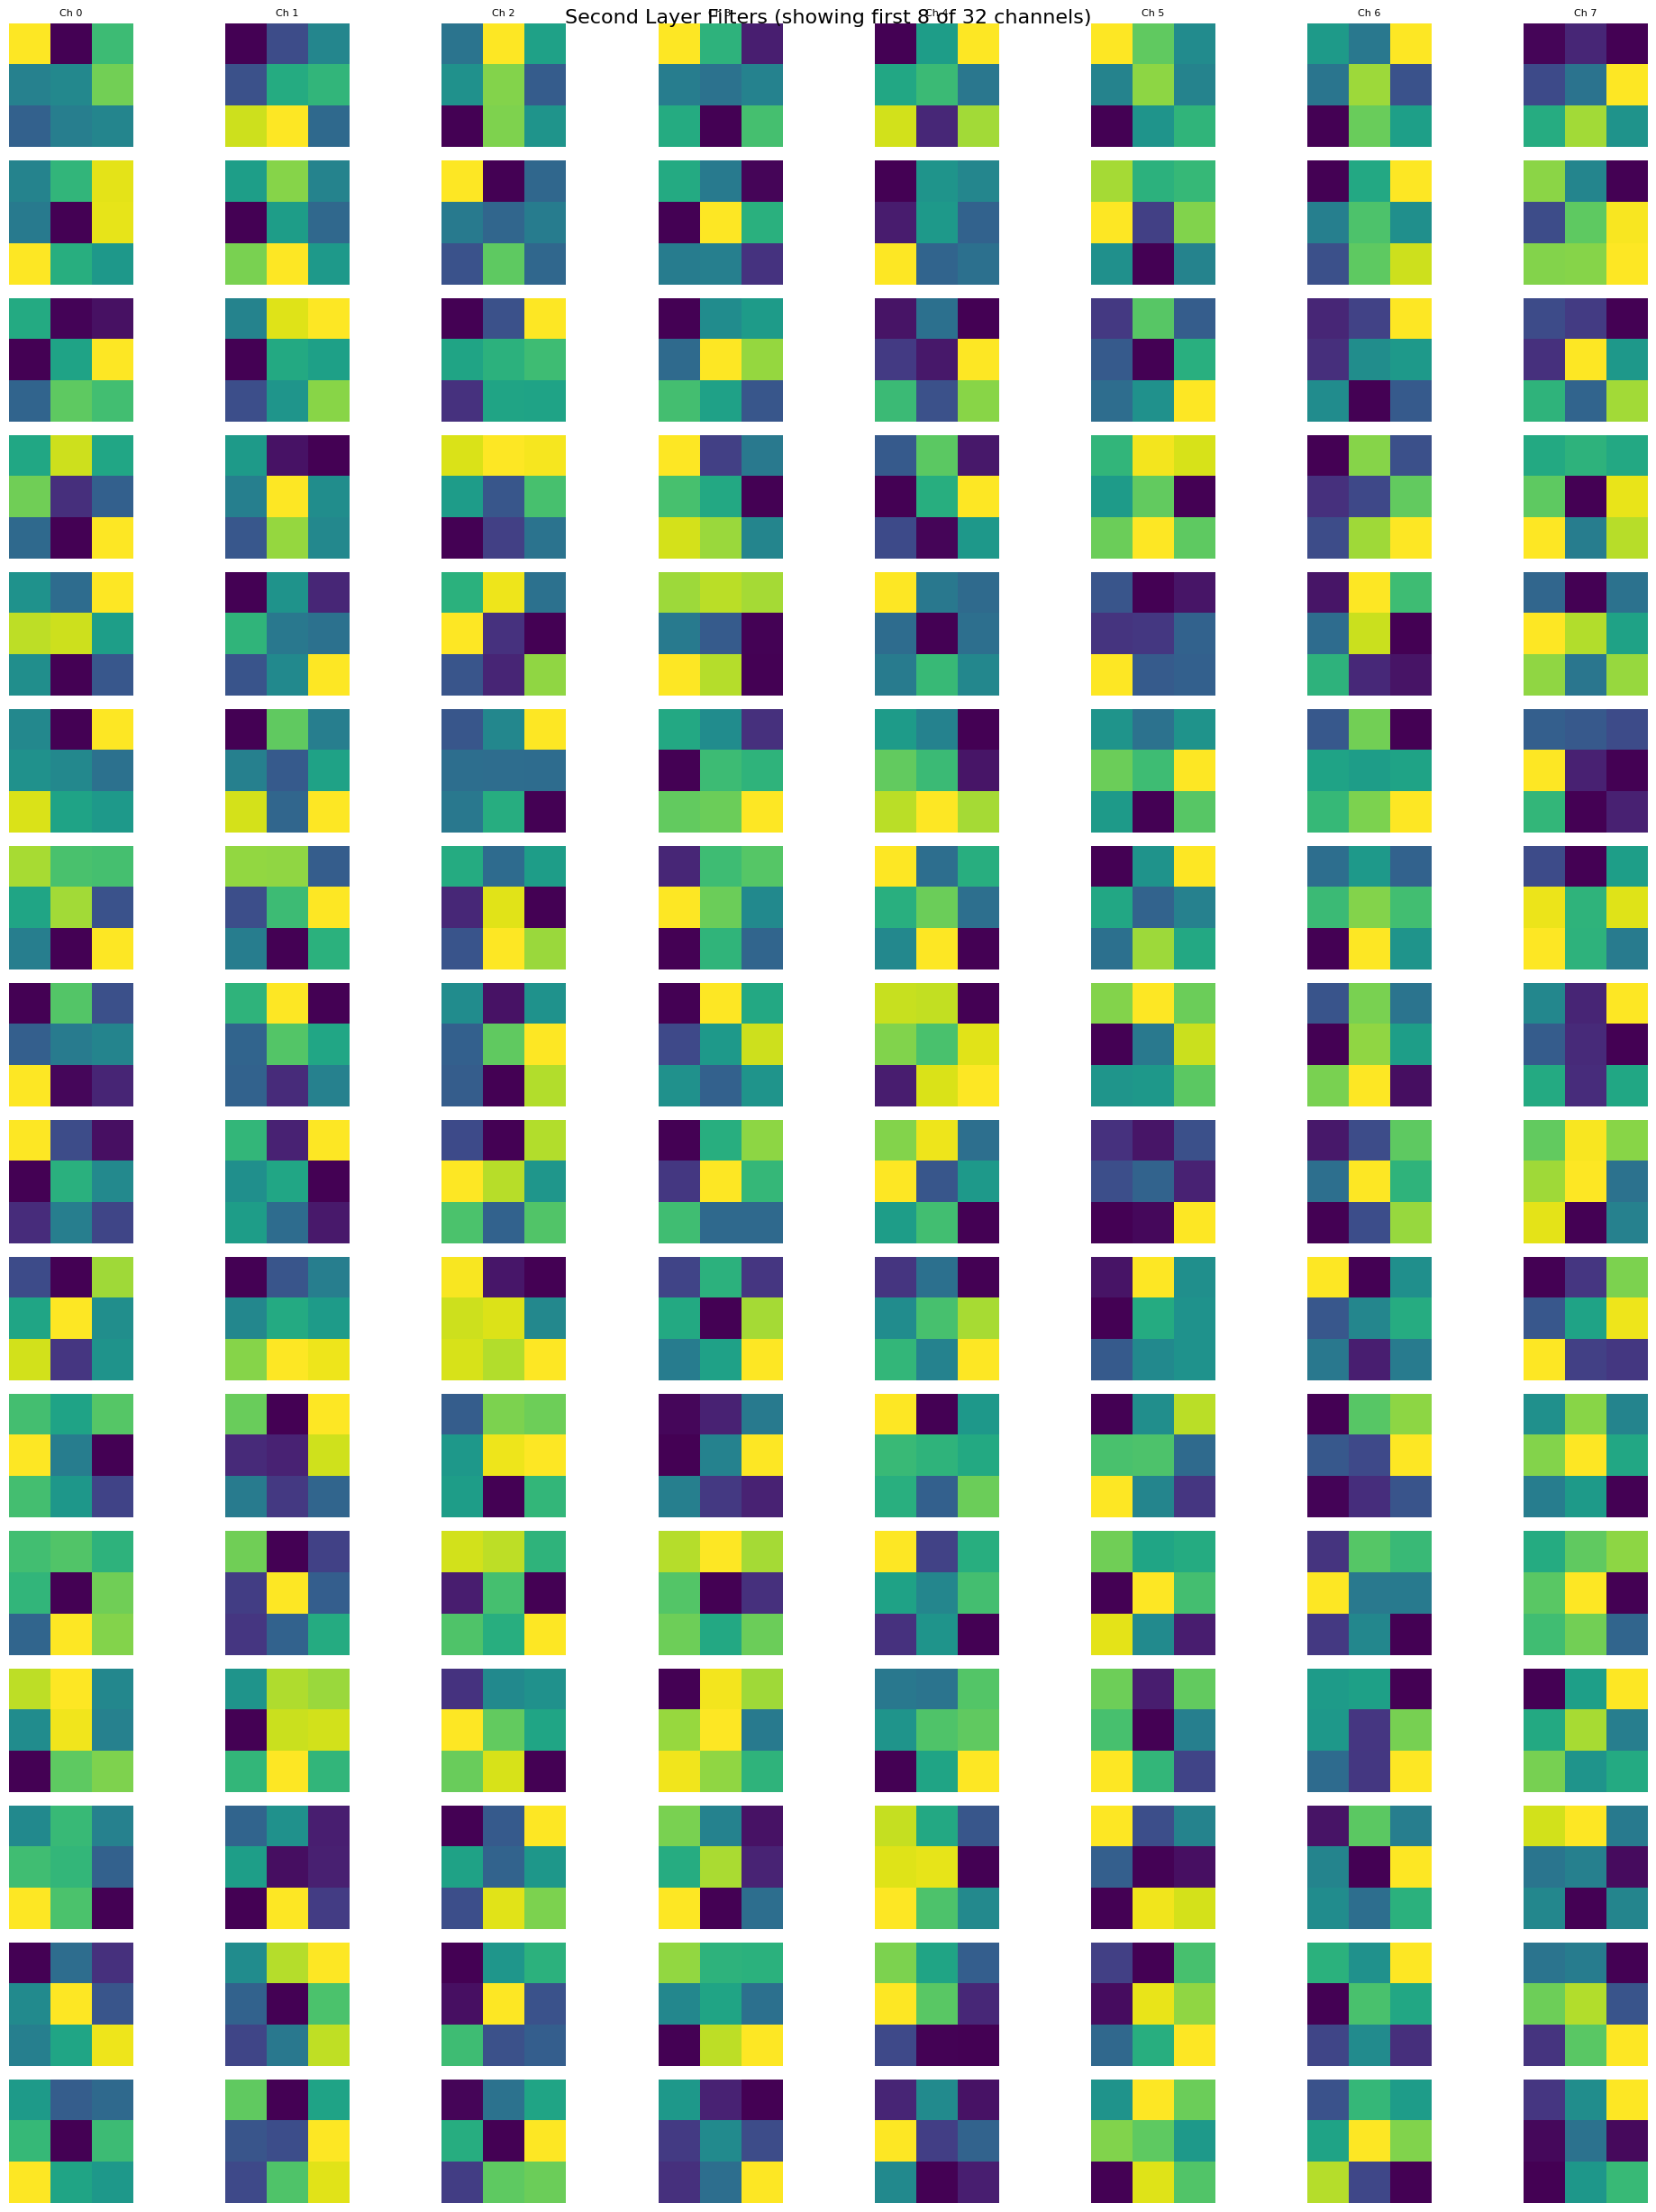

Saved to conv2_filters.png


In [50]:
visualize_conv2_filters(model_np)

Unfortunately these filters' visualizations are really difficult to make anything of. Instead of only the filters, we can visualize what is going on throughout a forward pass and visualize the outputs of the operations to get results that we can make sense of.

In [51]:
def visualize_activations(model, image, true_label, save_path='activations.png'):
  # Prepare image (add batch dimension)
  if image.ndim == 3:
    image = image.reshape(1, *image.shape)

  # Get activations by doing a forward pass and saving intermediate values
  dummy_label = np.zeros((1, 10))
  _, cache, _ = model.forward(image, dummy_label)

  # Extract activations
  conv1_act = cache['relu1_out'][0]  # (32, 32, 32)
  pool1_act = cache['pool1_out'][0]  # (32, 16, 16)
  conv2_act = cache['relu2_out'][0]  # (64, 16, 16)
  pool2_act = cache['pool2_out'][0]  # (64, 8, 8)

  # Create visualization
  fig = plt.figure(figsize=(20, 12))

  # Original image
  ax = plt.subplot(4, 9, 1)
  img_display = image[0].transpose(1, 2, 0)  # (32, 32, 3)
  ax.imshow(img_display)
  ax.set_title(f'Input\n{dataset_full.classes[true_label]}', fontsize=10)
  ax.axis('off')

  # Conv1 activations (show first 8 of 32)
  for i in range(8):
    ax = plt.subplot(4, 9, i + 2)
    ax.imshow(conv1_act[i], cmap='viridis')
    ax.set_title(f'Conv1-{i}', fontsize=8)
    ax.axis('off')

  # Pool1 activations (show first 8 of 32)
  for i in range(8):
    ax = plt.subplot(4, 9, i + 10)
    ax.imshow(pool1_act[i], cmap='viridis')
    ax.set_title(f'Pool1-{i}', fontsize=8)
    ax.axis('off')

  # Conv2 activations (show first 8 of 64)
  for i in range(8):
    ax = plt.subplot(4, 9, i + 19)
    ax.imshow(conv2_act[i], cmap='plasma')
    ax.set_title(f'Conv2-{i}', fontsize=8)
    ax.axis('off')

  # Pool2 activations (show first 8 of 64)
  for i in range(8):
    ax = plt.subplot(4, 9, i + 28)
    ax.imshow(pool2_act[i], cmap='plasma')
    ax.set_title(f'Pool2-{i}', fontsize=8)
    ax.axis('off')

  plt.suptitle('Activation Maps Through Network Layers', fontsize=14)
  plt.tight_layout()
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
  plt.show()
  print(f"Saved to {save_path}")

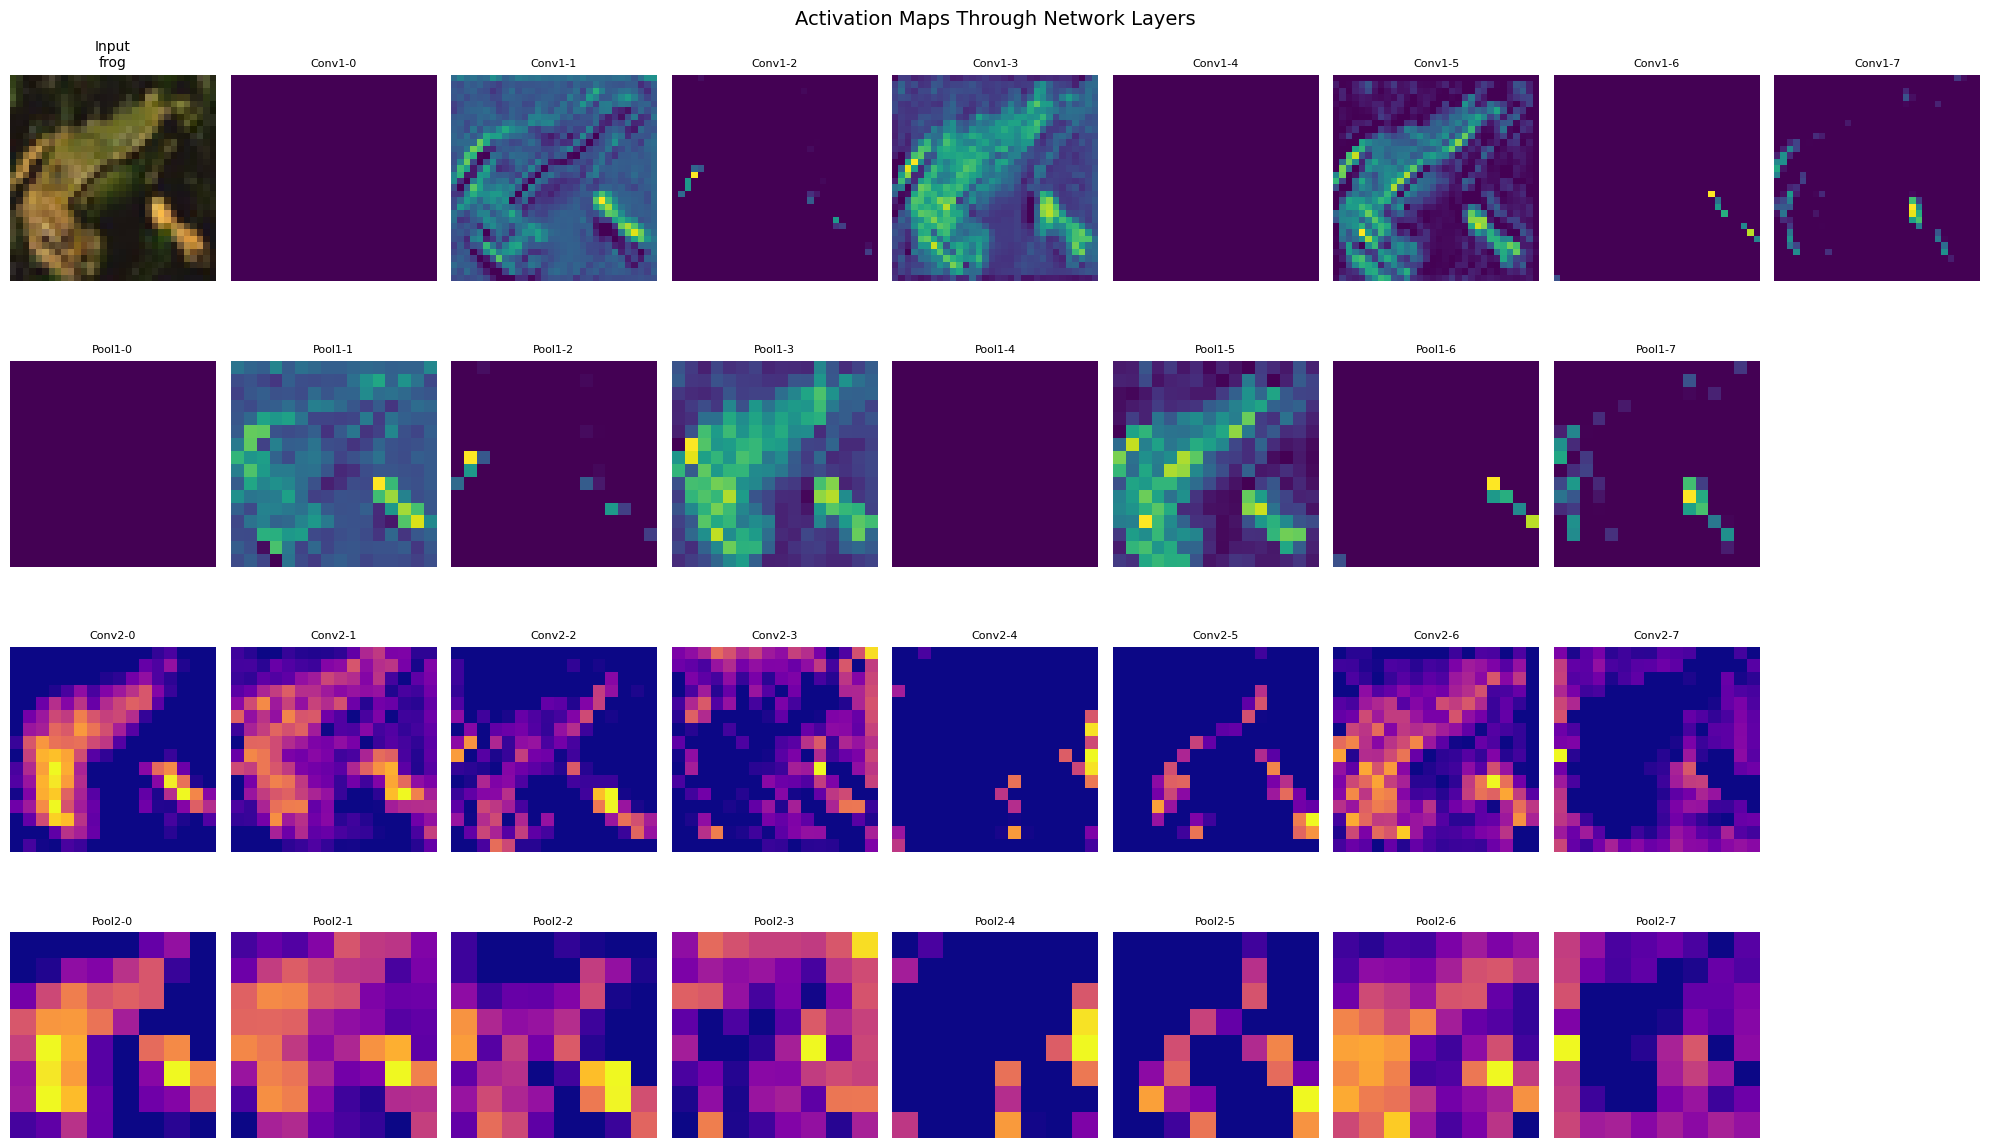

Saved to test_activations.png


In [54]:
# Use it on a test image
test_idx = 41
visualize_activations(model_np, X_test_scaled[test_idx], y_test[test_idx], 'test_activations.png')

It can be seen that in most of the outputs, the outline of the frog is visible. Some convolution results focus on different parts of the images and some of them are still abstract to us but it is definitely interesting to see the inner processes of a model trying to classify an image.
# 8 - Key Insights
* Scaling (normalizing) the data is done to help models converge faster.
* Manually creating a CNN model is pretty complicated but definitely doable. Though Their performance is not that good.
* Padding is done to not lose edge information when running convolutions.
* Running im2col transformation to data makes convolution much faster as it becomes a simple matrix multiplication.
* Max Pooling also helps decrease computational complexity by reducing the spatial dimensions of tha data.
* After the Convolution and Pooling operations, the data is flattened to use as input to the Dense (Fully Connected) layers.
* He initialization with ReLU is a better way to initialize weights than random initialization.
* Visualising learned filters and activations give us insights about how the model is processing the date throughout a forward pass.